## Imports

In [ ]:
# Create a data set ....
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import xavier_normal_ , uniform_
from torch.utils.data import Dataset,DataLoader
import fastai
from fastai.data_block import FloatList
from fastai.basic_train import *
from fastai.metrics import *
import random; 

import os

def model_summary(net) :
    #print(net.children)
    header = "{:<30}{:<30}{:<20}".format("Layer" ,"Weight Size", "#Params")
    print(header)
    print("="*70)
    tp = 0
    for (ln,i) in net.named_parameters() :
        #print(ln, i.size(),np.prod(np.asarray(i.size())))
        trainable_params = np.prod(np.asarray(i.size()))
        ln_out = "{:<30}{:<30}{:<20}".format(ln , str(i.size()), trainable_params)
        print(ln_out)
        tp += trainable_params
    print("="*70)
    print("Total params: {}".format(tp))

def set_device(MODE,num=0) :
#MODE = "GPU" # CPU
    device=None
    if(MODE=="GPU") :
        os.environ["CUDA_VISIBLE_DEVICES"] = str(num)
        print('CUDA available: {}  Using device {}'.format(torch.cuda.is_available(), os.environ['CUDA_VISIBLE_DEVICES']))
        device = torch.device('cuda')
    else :
        device = torch.device('cpu')
    return device


In [ ]:
d = set_device("GPU",3)

## Create a Synthetic DataSet

In [ ]:
def create_data_set(NP=1000,p=0.05) :
    # Create a sample time series
    x_range = int(NP/10) # basically a point every 0.1 in x ..
    print("Creating Dataset : Num Points = {} Reset prob = {}".format(NP,p))
    print("Sine wave with {} samples over x range of {}".format(NP,x_range))
    ii=np.linspace(0,x_range,num=NP)
    a = np.sin(ii)
    b = np.random.choice([0,1],size=NP,p=[p,1-p])
    b2 = np.zeros(NP)
    c = np.zeros(NP)
    idx=0
    for i in range(NP) :
        if(b[i]==0 or i==0):
            idx=0
            b[i]=0
        c[i] = a[idx]
        b2[i] = idx
        idx+=1
    c_prev = np.zeros(NP)
    c_prev[1:NP] = c[0:NP-1]
    
    X = np.stack((a,b,b2,c_prev),axis=1)
    y = c
    columns=['ii','a','b','b2','c_prev','c']
    return(ii,X,y,columns)
    

In [ ]:
class CustomDataset(Dataset):
    # y_offset is cycles into future
    def __init__(self,NP,Tx=70,y_offset=0,num_features=1):
        ii,X,y,columns = create_data_set(NP=NP)
        self.X=X
        self.y=y
        self.columns=columns
        self.NP=NP
        self.Tx=Tx
        self.y_offset=y_offset
        self.num_features=num_features
        if(num_features == 1) : print("Warning only returning one feature (reset).\n  Hack around with CustomDataset to get what you want")
        elif(num_features == 2) : print("Warning only returning two features (reset and counter)\n.  Hack around with CustomDataset to get what you want")
        elif(num_features == 2) : print("Warning only returning 4 features (orig_sin, reset and counter, prev)\n.  Hack around with CustomDataset to get what you want")
        else : print("Warning , verify what you want and add some code here")
        
    def __len__(self):
        return len(self.X)
    
    # this returns numpy arrays ....
    def __getitem__(self, idx):
        print(idx)
        # simple fix to going out of bounds
        if(idx > NP-self.Tx - 1) :
            idx -= self.Tx
        X=self.X[idx:idx+self.Tx]
        y=self.y[idx+self.y_offset:idx+self.Tx+self.y_offset]
        if(len(X) < self.Tx) :
            print("error idx = {}".format(idx))
        if(self.num_features == 1) : # just return the 'reset signal'
            X=X[:,1:2]
        elif(self.num_features == 2) :
            X=X[:,1:3]
        elif(self.num_features == 4) :
            # do nuttin
            X=X
        
        X = torch.from_numpy(X).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)
        return (X,y)

# Custom Collate function to take a set of tuples (Seqlen x numfeatures) and convert to
# (Seqlen x batch x numfeatures)
def collate_fn(data):
    """
       data: is a list of tuples with (X, y)

    """
    # collate X, y
    X, y  = zip(*data)
    X=torch.stack( X, axis=1 )
    y=torch.stack( y, axis=1 )
    
    print(len(X),type(X),X.size())
    print(len(y),type(y),y.size())

    return (X,y)


In [ ]:
print("np.sin is in radians")
NP=10000
dataset = CustomDataset(NP=NP,Tx=70,num_features=1)
(x0,y0) = dataset[0]
dl = DataLoader(dataset, collate_fn=collate_fn, batch_size=6,shuffle=True)

In [ ]:
(X,y) = next(iter(dl))
X
#$for _ in range(100) :
#$    
#$    type(X)
#$#print(X.size())
#$X.to(d)

### Visualize Data 

In [ ]:
# X:,0 is a... just a sine wave ...
# resets when b equals zero
plt.figure(figsize=(25,5))
display(plt.plot(x0[:,0],'-bo',markersize=5))
display(plt.plot(x0[:,1],'-bo',markersize=5))

display(plt.plot(y0,'-go',markersize=10))


### Chuck it in a DF


In [ ]:
print(x0.shape)
print(y0.shape)
df=pd.DataFrame(x0, columns=['a','b','b2','c_prev'])
df["y"] = y0

df.head(20) # 2*pi 6.28

In [ ]:
### Datablock API
# https://docs.fast.ai/data_block.html

## Build a fastai databunch from np array

## RNN Using pytorch RNN library

In [ ]:
# Initialize with Xavier normal distribuition        
def weights_xavier(m):
    if isinstance(m, nn.Conv2d):
        xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear) :
        xavier_normal_(m.weight.data)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.RNN) :
        xavier_normal_(m.weight_ih_l0.data)
        xavier_normal_(m.weight_hh_l0.data)
        m.bias_ih_l0.data.fill_(0)
        m.bias_hh_l0.data.fill_(0)

### Generic RNN Code Sample

In [ ]:
# # initialize the hidden state.
if(0) :
    rnn_model = nn.RNN(num_features, hidden_size, num_layers)  # Input dim is 3, output dim is 3
    final_layer = nn.Linear(hidden_size,1)
    
    rnn_model.apply(weights_xavier)
    
    hidden_rnn = torch.randn(num_layers, batch_size, hidden_size)
    inputs = torch.randn(Tx,batch_size,num_features)
    
    print(inputs.size())
    print(hidden_rnn.size())
    out, hidden = rnn_model(inputs, hidden_rnn)
    o = out[Tx-1].view(-1)
    final_layer(o)

### Instantiate DVRNN

![Image of Yaktocat  https://github.ibm.com/vanstee/aicoc-ai-immersion/raw/master/nb_images/lstm_rnn.png 
![Image of Yaktocat    ../nb_images/lstm_rnn.png)

In [ ]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html


class DVRNN(nn.Module) :
    def __init__(self,nf,tx,hs,nl) :
        super(DVRNN,self).__init__()
        self.name = "DVRNN"
        self.tx=tx
        self.num_features=nf
        self.hidden_size=hs
        self.rnn = nn.RNN(nf, hs, nl)
        self.fc = nn.Linear(hs, 1)
    
    def forward(self, x, h, all_outputs=True):
        
        out1, hidden = self.rnn(x, h)
        bs=x.size()[1] # batchsize hard coded
        if(all_outputs == False) :
            out3 = torch.zeros(1,bs,1).to(d) 
            for b in range(bs) :
                out2 = out1[self.tx-1,b].view(-1)
                out3[0,b,0] = self.fc(out2)
        else :
            #print("batch_size={}".format(bs))
            out3 = torch.zeros(self.tx,bs,1).to(d) 
            for i in range(self.tx) :
                for b in range(bs) :
                    out2 = out1[i,b,:].view(-1)
                    out3[i,b,0] = self.fc(out2)
        return out3,hidden.detach()
    
    # reset all parameters of model 
    def init_params(self) :
        self.apply(weights_xavier)

class DVLSTM(nn.Module) :
    def __init__(self,nf,tx,hs,nl) :
        super(DVLSTM,self).__init__()
        self.name = "DVLSTM"
        self.tx=tx
        self.num_features=nf
        self.hidden_size=hs
        self.lstm = nn.LSTM(nf, hs, nl, bidirectional=False)  # bidirectional=True
        self.fc = nn.Linear(hs, 1) # *2 for bidi
    
    def forward(self, x, h, all_outputs=True):
        
        out1, (h,c) = self.lstm(x, h)
        bs=x.size()[1] # batchsize hard coded
        if(all_outputs == False) :
            out3 = torch.zeros(1,bs,1).to(d) 
            for b in range(bs) :
                out2 = out1[self.tx-1,b].view(-1)
                out3[0,b,0] = self.fc(out2)
        else :
            out3 = torch.zeros(self.tx,bs,1).to(d) 
            for i in range(self.tx) :
                for b in range(bs) :
                    out2 = out1[i,b,:].view(-1)
                    out3[i,b,0] = self.fc(out2)
            
        return out3,(h.detach(),c.detach())
    
    # reset all parameters of model 
    def init_params(self) :
        self.apply(weights_xavier)  


## Train RNN

In [ ]:
# Build X, y
# Added in time lagged y (c_prev)
torch.manual_seed(0)
NP=3008
Tx = 70          # sequence length 
hidden_size = 50  # number of features of hidden state
num_layers  = 1  # this is for stacked implementations.  Keep 1 for now
batch_size = 16
num_features = 1 # aka input_size, aka number of columns in X
reset_prob = 0.05


hidden_lstm = (torch.zeros(num_layers, batch_size, hidden_size).to(d),torch.zeros(num_layers, batch_size, hidden_size).to(d))
dataset = CustomDataset(NP=NP,Tx=Tx)
dataloader = DataLoader(dataset, collate_fn=collate_fn, 
                        batch_size=batch_size,shuffle=True,num_workers=30)
def print_run() :
    print("NP           : {}".format(NP))
    print("num_features : {}".format(num_features))
    print("Tx : {}".format(Tx))
    print("hidden_size : {}".format(hidden_size))
    print("num_layers : {}".format(num_layers))
    print("batch_size : {}".format(batch_size))
    print("reset_prob : {}".format(reset_prob))
print_run()


In [ ]:
# Setup Custom RNN
torch.manual_seed(1)

dvrnn = DVRNN(num_features,Tx,hidden_size,num_layers).to(d)
dvrnn.init_params()

dvlstm = DVLSTM(num_features,Tx,hidden_size,num_layers).to(d)
dvlstm.init_params()

#dvrnn.train()
#optimizer = optim.SGD(dvrnn.parameters(), lr=0.1)
loss_function = nn.MSELoss()  # L1Loss

In [ ]:
#forward pass tests

(x_tx, y_tx) = next(iter(dataloader))
x_tx = x_tx.to(d)

print(x_tx.size())
print(x_tx.size(-1))
print(hidden_rnn.size())
#dvrnn.rnn(x_tx.to(d), hidden_rnn.to(d))
(o,h) = dvrnn(x_tx, hidden_rnn)
assert(o.size() == torch.Size([Tx, batch_size, 1])) # output dimension is one, since we are regressing to a number

(o,h) = dvrnn.forward(x_tx, hidden_rnn,all_outputs=False)
# just grabs the last output
print(o.size())
assert(o.size() == torch.Size([1,batch_size,1])) # output dimension is one, since we are regressing to a number


In [ ]:
#print(list(dvlstm.lstm.named_parameters()))
#dvlstm.lstm.weight_hh_l0.grad
def lstm_wg_stats() :
    
    h = "{:<15s} {:<10s} {:<10s} {:<10s} {:<10s}".format("layer", "wght mean", "wght std", "grad mean", "grad std")
    print(h)
    for layer,values in list(dvlstm.lstm.named_parameters()) :
        #print(layer)
        #print(values.view(-1).mean())
        #print(values.view(-1).std())
        #print(values.grad.view(-1).mean())
        #print(values.grad.view(-1).std())
        h = "{:<15s} {:10.4f} {:10.4f} {:10.4f} {:10.4f}".format(layer, values.view(-1).mean(),values.view(-1).std(),values.grad.view(-1).mean(),values.grad.view(-1).std())
        print(h)
        
#lstm_wg_stats()

In [ ]:
# Train
# 10 epoch @ 0.01
# 10 epoch @ 0.001
#optimizer = optim.Adam(dvrnn.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer_rnn = optim.Adam(dvrnn.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer_lstm = optim.Adam(dvlstm.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# all outputs specifies if you want seq to seq for each step of the RNN/LSTM
def train_instance(iteration,x_tx,y_tx, model, opt, hidden_init, all_outputs) :
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    dvrnn.zero_grad()
            
    # Step 2. Run our forward pass.
    yhat, _ = model(x_tx, hidden_init)
 
    # Step 3. Compute the loss, gradients, and update the parameters by
    loss = loss_function(yhat, y_tx)
    loss.backward()
    opt.step()
    return loss.item()

def save_model(name,model,path="./") :
    torch.save(model.state_dict(), path+name)

# Training Loop
for epoch in range(20):  # again, normally you would NOT do 300 epochs, it is toy data
    epoch_rnn_loss=epoch_lstm_loss=0
    # Create a new dataset each epoch ...
    dataset = CustomDataset(NP=NP,Tx=Tx)
    dataloader = DataLoader(dataset, collate_fn=collate_fn, 
                        batch_size=batch_size,shuffle=True,num_workers=8)
    loop_count=0
    for (i, (X,y)) in enumerate(dataloader):
        #print("Iteration: {} {}".format(epoch,i))
        X=X.to(d)
        y=y.unsqueeze(-1).to(d)
        epoch_rnn_loss += train_instance(i,X,y,dvrnn,optimizer_rnn,hidden_rnn,all_outputs=True)
        #epoch_lstm_loss += train_instance(i,X,y,dvlstm,optimizer_lstm,hidden_lstm,all_outputs=True)
        loop_count += 1
    # Normalize per training example
    epoch_rnn_loss /= loop_count # dataloader samples all NP samples ..
    #epoch_lstm_loss /= loop_count
    print("Epoch {} mean loss: RNN {} LSTM {}".format(epoch, epoch_rnn_loss,epoch_lstm_loss))
    plot_results()
    save_model("rnn_{}_{:1.2f}.pth".format(epoch,epoch_rnn_loss),dvrnn)
    #lstm_wg_stats()


In [ ]:
bs=1
Epoch 0 loss: RNN 84.49429889768362 LSTM 85.23977077752352
Epoch 0 loss/inst: RNN 0.4224714944884181 LSTM 0.4261988538876176
Iteration: 0 176
loss:0.1366077959537506
loss:0.40847358107566833

bs=4
Epoch 0 loss: RNN 19.573494464159012 LSTM 21.002969831228256
Epoch 0 loss/inst: RNN 0.3914698892831802 LSTM 0.42005939662456515

bs=100    
Epoch 0 loss: RNN 0.6468528807163239 LSTM 0.7300841808319092
Epoch 0 loss/inst: RNN 0.3234264403581619 LSTM 0.3650420904159546


...

# TODO
# Add GRU
# Add Validation
# Add batch for speed up
# ADD layered ?

## Visualize RNN

In [ ]:
# Show generative result
i=200

# This is how you can hard code batch size=1 and control the index for graphing
(x_tx,y_tx)= collate_fn([dataset[0]])

#print_run()
print(x_tx.size())
#x_tx = x_tx.to(d)
#yhat, _ = dvrnn(x_tx, hidden_rnn)

def plot_results() :
    ypred = torch.zeros(200).to(d)
    yact  = torch.zeros(200).to(d)
    hidden_rnn_plt = torch.zeros(num_layers, 1, hidden_size).to(d)
    for g_idx in range(0,200):
        (x_tx,y_tx)= collate_fn([dataset[g_idx]])
        x_tx = x_tx.to(d)
        yhat, _ = dvrnn(x_tx, hidden_rnn_plt)
        
        ypred[g_idx] = yhat[-1].view(-1)
        yact[g_idx] = y_tx[-1].view(-1)
        #print(ypred[g_idx])
        #print(yhat,y[i+dvrnn.tx],X[i+dvrnn.tx])
        
    #print(ypred)
    ypred = ypred.cpu().detach().numpy()
    plt.plot(ypred)
    yact = yact.cpu().detach().numpy()
    plt.plot(yact)
    display(plt.show())
plot_results()


### Some simple results for now

Reset Prob @ 20% 15 epochs @ 0.001, 5 @ 0.0001
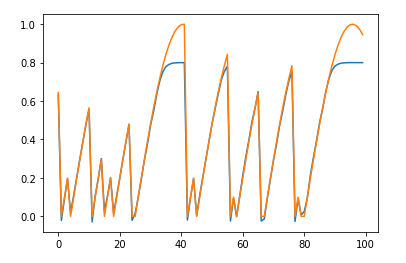

In [ ]:
list(dvrnn.parameters())[0]

In [ ]:
dvrnn.rnn.weight_hh_l0.grad

In [ ]:
# lstm ...
#lstm = nn.LSTM(3, 3)  # Input/Embedding dim is 3, output dim is 3, 
#hidden = (torch.randn(1, 1, 3),
#          torch.randn(1, 1, 3))
